# 비전 트랜스포머로 이미지 분류 (Image classification with Vision Transformer)

**저자:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)  
**생성일:** 2021/01/18  
**최종편집일:** 2021/01/18  
**설명:** 이미지 분류를 위한 비전 트랜스포머(ViT) 모델 구현하기

## 소개

이 예는 이미지 분류를 위해 Alexey Dosovitskiy 등이 개발한 [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) 모델을 구현하고, CIFAR-100 데이터 세트에 대해 이를 시연합니다. ViT 모델은, 컨볼루션 레이어를 사용하지 않고, 이미지 패치 시퀀스에 셀프 어텐션으로 트랜스포머 아키텍처를 적용합니다.

## Keras 3

In [2]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

## 셋업

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## 데이터 준비

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 268s 2us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 하이퍼파라미터 구성

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # 실제 트레이닝의 경우, num_epochs=100을 사용합니다. 10은 테스트 값입니다.
image_size = 72  #입력 이미지의 크기를 이 크기로 조정합니다.
patch_size = 6  # 입력 이미지에서 추출할 패치 크기
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # 트랜스포머 레이어의 크기
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # 최종 분류기의 Dense 레이어 크기


## 데이터 보강 사용

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# 정규화를 위해 트레이닝 데이터의 평균과 분산을 계산합니다.
data_augmentation.layers[0].adapt(x_train)

## 다층 퍼셉트론(MLP) 구현

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## 레이어로서 패치 생성 구현

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

샘플 이미지에 대한 패치를 표시해 보겠습니다.

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


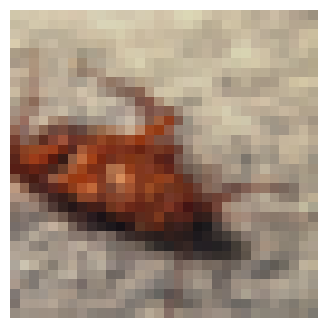

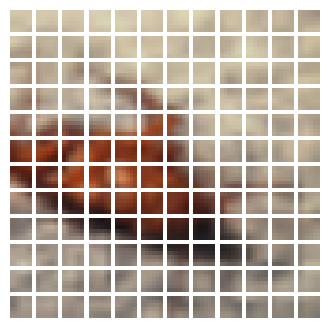

In [9]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## 패치 인코딩 레이어 구현

`PatchEncoder` 레이어는 패치를 `projection_dim` 크기의 벡터로 투영하여 선형적으로 변환합니다. 또한, 투영된 벡터에 학습 가능한 위치 임베딩을 추가합니다.

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

## ViT 모델 빌드

ViT 모델은 패치 시퀀스에 적용되는 셀프 어텐션 메커니즘으로서 `layers.MultiHeadAttention` 레이어를 사용하는, 여러 트랜스포머 블록으로 구성됩니다. 트랜스포머 블록은 `[batch_size, num_patches, projection_dim]` 텐서를 생성하고, 이 텐서는 소프트맥스가 있는 분류기 헤드를 통해 처리되어 최종 클래스 확률 출력을 생성합니다.

[논문](https://arxiv.org/abs/2010.11929)에서 설명한 기법 즉, 인코딩된 패치 시퀀스에 학습 가능한 임베딩을 추가하여 이미지 표현으로 사용하는 것과 달리, 최종 Transformer 블록의 모든 출력은 `layers.Flatten()`으로 reshape 되어 분류기 헤드에 입력되는 이미지 표현으로 사용됩니다. 특히 패치 수와 투영 치수가 많은 경우, `layers.GlobalAveragePooling1D` 레이어를 대신 사용하여, Transformer 블록의 출력을 집계할 수도 있습니다.

In [11]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # 데이터 보강.
    augmented = data_augmentation(inputs)
    # 패치 생성.
    patches = Patches(patch_size)(augmented)
    # 패치 인코딩.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # 트랜스포머 블록의 여러 레이어를 생성합니다.
    for _ in range(transformer_layers):
        # 레이어 정규화 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # 멀티 헤드 어텐션 레이어를 생성.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # 스킵 연결 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # 레이어 정규화 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # 스킵 연결 2.
        encoded_patches = layers.Add()([x3, x2])

    # [batch_size, projection_dim] 텐서를 생성.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # MLP 추가.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # 출력을 분류.
    logits = layers.Dense(num_classes)(features)
    # Keras 모델을 생성.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## 모드 컴파일, 트레이닝 및 평가하기

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 153s 814ms/step - accuracy: 0.0308 - loss: 4.8928 - top-5-accuracy: 0.1130 - val_accuracy: 0.1114 - val_loss: 3.9051 - val_top-5-accuracy: 0.3214
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 160s 909ms/step - accuracy: 0.0831 - loss: 4.0206 - top-5-accuracy: 0.2693 - val_accuracy: 0.1600 - val_loss: 3.5502 - val_top-5-accuracy: 0.4142
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.1255 - loss: 3.7295 - top-5-accuracy: 0.3527 - val_accuracy: 0.1962 - val_loss: 3.3094 - val_top-5-accuracy: 0.4798
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.1593 - loss: 3.5117 - top-5-accuracy: 0.4171 - val_accuracy: 0.2220 - val_loss: 3.2029 - val_top-5-accuracy: 0.5034
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.1796 - loss: 3.3742 - top-5-accuracy: 0.4576 - val_accuracy: 0.2574 - val_loss: 3.0040 - val_top-5-accuracy: 0.5588
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.2148 - loss:

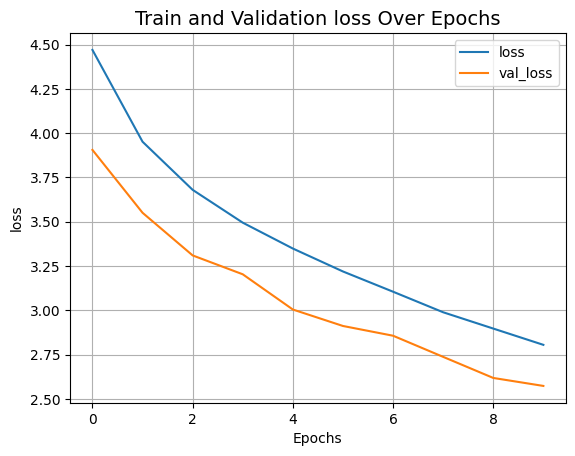

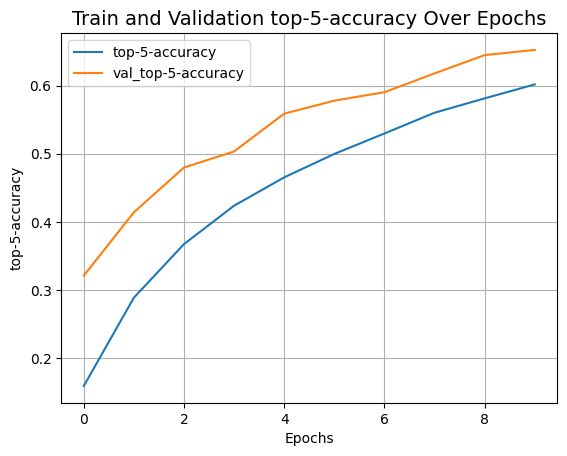

In [12]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

100 에포크가 지난 후, ViT 모델은 테스트 데이터에 대해 약 55%의 정확도와 82%의 top-5 정확도를 달성했습니다. 동일한 데이터에 대해 처음부터 트레이닝된 ResNet50V2는 67%의 정확도를 달성할 수 있기 때문에, 이는 CIFAR-100 데이터 세트에 대해서는 경쟁력이 없는 결과입니다.

[논문](https://arxiv.org/abs/2010.11929)에 보고된 최신 결과는 JFT-300M 데이터 세트를 사용하여 ViT 모델을 사전 트레이닝한 후, 목표 데이터 세트에 대해 미세 조정하여 달성한 결과라는 점에 유의하세요. 사전 트레이닝 없이 모델 품질을 개선하려면, 더 많은 에포크에 대해 모델을 트레이닝하거나, 더 많은 수의 트랜스포머 레이어를 사용하거나, 입력 이미지의 크기를 조정하거나, 패치 크기를 변경하거나, 투사 크기를 늘리는 등의 방법을 시도할 수 있습니다. 또한, 논문에서 언급했듯이, 모델의 품질은 아키텍처 선택뿐만 아니라, 학습률 스케쥴, 옵티마이저, 가중치 감쇠 등과 같은 매개 변수에 의해서도 영향을 받습니다. 실제로는, 대규모의 고해상도 데이터 세트를 사용하여 사전 트레이닝된 ViT 모델을 미세 조정하는 것이 좋습니다.
